In [1]:
import os
import cv2
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
input_shape = (128, 128, 3)
data_dir = 'dataset'

real_data = [f for f in os.listdir(data_dir+'/real') if f.endswith('.png')]
fake_data = [f for f in os.listdir(data_dir+'/fake') if f.endswith('.png')]

X = []
Y = []

for img in real_data:
    X.append(img_to_array(load_img(data_dir+'/real/'+img)).flatten() / 255.0)
    Y.append(1)
for img in fake_data:
    X.append(img_to_array(load_img(data_dir+'/fake/'+img)).flatten() / 255.0)
    Y.append(0)

Y_val_org = Y

#Normalization
X = np.array(X)
Y = to_categorical(Y, 2)

#Reshape
X = X.reshape(-1, 128, 128, 3)

#Train-Test split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)


In [3]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


googleNet_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
googleNet_model.trainable = True
model = Sequential()
model.add(googleNet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=2, activation='softmax'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 2, 2, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 3074      
Total params: 54,339,810
Trainable params: 54,279,266
Non-trainable params: 60,544
_________________________________________________________________


In [4]:
#Currently not used
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=2,
                               verbose=0, mode='auto')
EPOCHS = 20
BATCH_SIZE = 20
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = (X_val, Y_val), verbose = 1)

Train on 3300 samples, validate on 826 samples
Epoch 1/20
3300/3300 [==============================] - 64s 19ms/sample - loss: 0.5163 - accuracy: 0.7767 - val_loss: 0.6726 - val_accuracy: 0.7942
Epoch 2/20
3300/3300 [==============================] - 20s 6ms/sample - loss: 0.3966 - accuracy: 0.8409 - val_loss: 0.7248 - val_accuracy: 0.7942
Epoch 3/20
3300/3300 [==============================] - 21s 6ms/sample - loss: 0.3379 - accuracy: 0.8658 - val_loss: 0.7132 - val_accuracy: 0.8184
Epoch 4/20
3300/3300 [==============================] - 21s 6ms/sample - loss: 0.2818 - accuracy: 0.8964 - val_loss: 0.6363 - val_accuracy: 0.8571
Epoch 5/20
3300/3300 [==============================] - 21s 6ms/sample - loss: 0.2315 - accuracy: 0.9142 - val_loss: 0.6174 - val_accuracy: 0.8717
Epoch 6/20
3300/3300 [==============================] - 20s 6ms/sample - loss: 0.1947 - accuracy: 0.9348 - val_loss: 0.5928 - val_accuracy: 0.8826
Epoch 7/20
3300/3300 [==============================] - 21s 6ms/sample

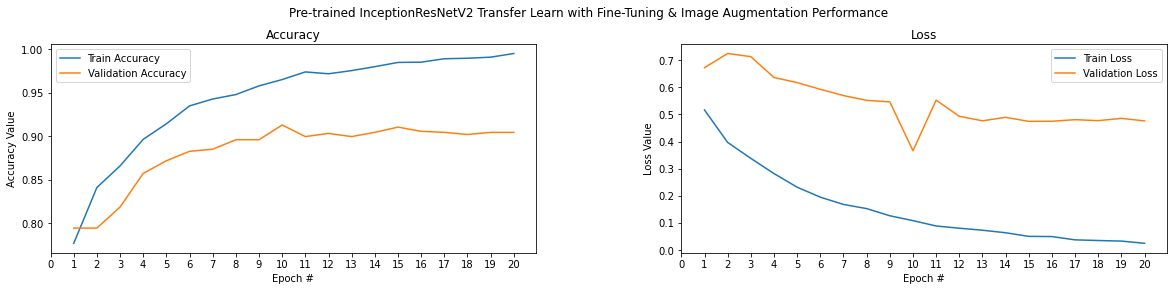

In [5]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Pre-trained InceptionResNetV2 Transfer Learn with Fine-Tuning & Image Augmentation Performance ', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,EPOCHS+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

True positive =  3142
False positive =  117
False negative =  41
True negative =  826




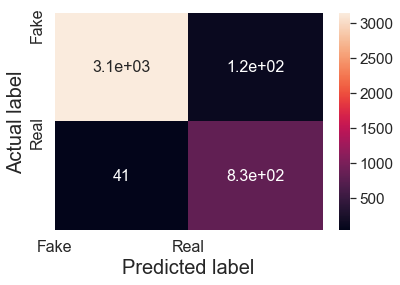

In [6]:
#Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    
print_confusion_matrix(Y_val_org, model.predict_classes(X))

In [7]:
model.save('deepfake-detection-model.h5')

In [8]:
model.load_weights('deepfake-detection-model.h5')

In [10]:
from mtcnn.mtcnn import MTCNN
import dlib
input_shape = (128, 128, 3)
pr_data = []
detector = dlib.get_frontal_face_detector()
cap = cv2.VideoCapture('test_videos/jzmzdispyo.mp4')
frameRate = cap.get(5)
while cap.isOpened():
            frameId = cap.get(1)
            ret, frame = cap.read()
            if ret != True:
                break
            if frameId % ((int(frameRate)+1)*1) == 0:
                # create the detector, using default weights
                  detector = MTCNN()
                # detect faces in the image
                  faces = detector.detect_faces(frame)
                  for i, d in enumerate(faces):
                        x1 = d['box'][0]
                        y1 = d['box'][1]
                        x2 = d['box'][2]
                        y2 = d['box'][3]
                        crop_img = frame[y1:y1+y2, x1:x1+x2, :]
                        data = img_to_array(cv2.resize(crop_img, (128, 128))).flatten() / 255.0
                        data = data.reshape(-1, 128, 128, 3)
                        print(model.predict_classes(data))
                        
    
     
    
    
    
    
            
            

Using TensorFlow backend.


[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
